## Feature Selection mit Korrelation & PPS

Um relevante Features für ein Modell zu extrahieren kann sowohl die Korrelation, als auch der PPS ein hilfreiches Tool sein. Welches der beiden Tools geeigneter ist, hängt immer von dem Anwendungsfall ab. In diesem Notebook wird gezeigt wie Sie beide Methoden anwenden können, um aussagekräftige Features zu finden, welche Ihnen Aufschluss über Ihr Dataset geben und später Ihnen die Feature Selection vereinfachen.

#### Imports

In [26]:
import pandas as pd
import ppscore as pps
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

In [80]:
df = pd.read_csv("../Datasets/titanic_training.csv", sep=",")
df = df.iloc[:,1:]

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


In [82]:
df.corr()

,survived,pclass,age,sibsp,parch,fare,adult_male,alone
survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,-0.557080,-0.203367
pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,0.094035,0.135207
age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.280328,0.198270
sibsp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.253586,-0.584471
parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,-0.349943,-0.583398
fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,-0.182024,-0.271832
adult_male,-0.557080,0.094035,0.280328,-0.253586,-0.349943,-0.182024,1.000000,0.404744
alone,-0.203367,0.135207,0.198270,-0.584471,-0.583398,-0.271832,0.404744,1.000000


In [83]:
matrix  = pps.matrix(df).pivot(columns='x', index='y',  values='ppscore')

<AxesSubplot:xlabel='x', ylabel='y'>

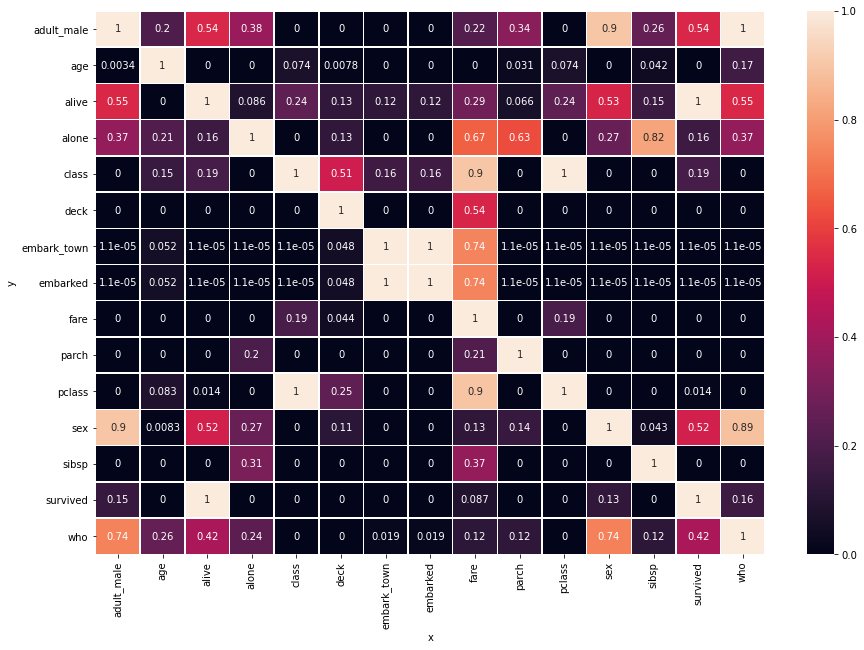

In [84]:
fig, ax = plt.subplots(figsize=(15,10))         # Sample figsize in inches
sns.heatmap(matrix, annot=True, linewidths=.5, ax=ax)

<AxesSubplot:>

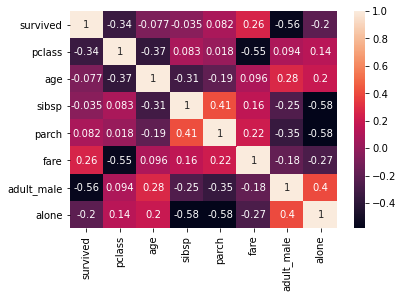

In [85]:
sns.heatmap(df.corr(),annot=True)

#### Behandlung von Fehlwerten

<AxesSubplot:>

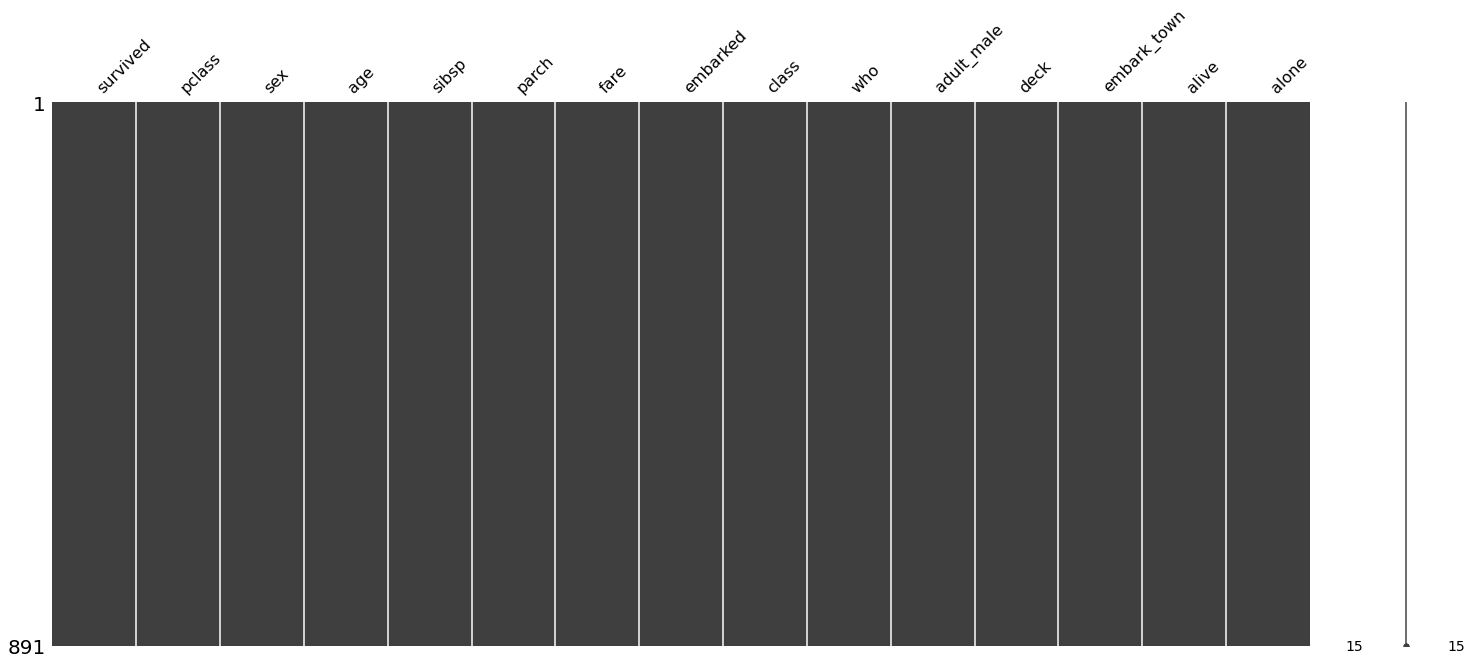

In [97]:
msno.matrix(df)

#### Modellbildung

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          891 non-null    object 
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     891 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         891 non-null    object 
 12  embark_town  891 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(1), int64(4), object(8)
memory usage: 92.4+ KB


In [101]:
del df['alive'] ## Cheat-Attribut löschen

In [89]:
df.age = df.age.astype("object")

In [90]:
df.loc[df.age.isna(),['age']] = "unknown" ## In Fehlwerten bei Alter könnte versteckte Information liegen, deshalb als unknown gekennzeichnet

In [96]:
df.loc[df.deck.isna(),['deck']] = "unknown" ## In Fehlwerten bei Alter könnte versteckte Information liegen, deshalb als unknown gekennzeichnet

In [91]:
df.loc[df.embarked.isna(),['embarked']] = df.embarked.mode()

In [94]:
df.loc[df.embark_town.isna() == True,['embark_town']]= df.embark_town.mode()[0]

In [98]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [102]:
X = pd.get_dummies(df.iloc[:,1:]) #Warum wird Name weggelassen obwohl der PPS besser ist,als bei horsepower?
y = df.survived

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

clf = DecisionTreeClassifier()

params = {
    "max_depth": range(1,10)
}

search = GridSearchCV(clf, params,cv=5)
search.fit(X_train,y_train)
search.score(X_test,y_test)

0.8212290502793296

In [103]:
search.best_params_

{'max_depth': 3}

#### Forward/Backward Selection

In [105]:
from sklearn.feature_selection import SequentialFeatureSelector

clf  = DecisionTreeClassifier(max_depth=3)
sfs = SequentialFeatureSelector(clf,n_features_to_select=None, direction='forward', cv=5) ## Bei n_features_to_select = None wird die Hälfte der Features gewählt

sfs.fit(X,y)

sfs.get_support()

array([False,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False, False, False,  True,
        True,  True,  True,  True, False, False,  True, False,  True,
        True, False, False,  True, False, False,  True,  True,  True,
        True, False, False,  True, False, False,  True, False, False,
        True, False, False, False,  True, False, False,  True, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False,  True, False,  True, False, False,
       False, False, False,  True,  True, False,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True, False, False,  True, False])

In [106]:
new_X = X.loc[:,sfs.get_support()] ##Benutzen der Maske um Features auszuwählen

In [107]:
X_train, X_test, y_train, y_test = train_test_split(new_X,y, test_size=0.2)

clf = DecisionTreeClassifier()

params = {
    "max_depth": range(1,10)
}

search = GridSearchCV(clf, params,cv=5)
search.fit(X_train,y_train)
search.score(X_test,y_test)

0.8156424581005587